### 0. Setup

Import the libraries we need.

In [ ]:
! pip install ISLP
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.compat import lzip
import seaborn as sns
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

### 1. Import data

Load the data, and explore the relationship among all the attributes.


### Overview
The **Boston Housing Dataset** contains information on **506 housing units** in the suburbs of Boston, with **13 features** used to predict the median value of homes in different neighborhoods. Each sample in the dataset represents the statistical information of a particular area.

### Features
The dataset typically includes the following variables:

1. **CRIM**: Per capita crime rate by town
2. **ZN**: Proportion of residential land zoned for lots over 25,000 sq. ft.
3. **INDUS**: Proportion of non-retail business acres per town
4. **CHAS**: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. **NOX**: Nitric oxides concentration (parts per 10 million)
6. **RM**: Average number of rooms per dwelling
7. **AGE**: Proportion of owner-occupied units built prior to 1940
8. **DIS**: Weighted distances to five Boston employment centers
9. **RAD**: Index of accessibility to radial highways
10. **TAX**: Full-value property tax rate per \$10,000
11. **PTRATIO**: Pupil-teacher ratio by town
12. **B**: Calculation \( B = 1000(Bk - 0.63)^2 \) where Bk is the proportion of Black residents
13. **LSTAT**: Percentage of the population considered lower status
14. **MEDV**: Median value of owner-occupied homes (in \$1000s)



In [ ]:
Boston = load_data("Boston")
print(Boston.shape)
print(Boston.columns)

(506, 13)
Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')


In [ ]:
Boston.isna().any()

,0
crim,False
zn,False
indus,False
chas,False
nox,False
rm,False
age,False
dis,False
rad,False
tax,False


In [ ]:
Boston[['crim', 'zn','indus', 'chas', 'nox']]

,crim,zn,indus,chas,nox
0,0.00632,18.0,2.31,0,0.538
1,0.02731,0.0,7.07,0,0.469
2,0.02729,0.0,7.07,0,0.469
3,0.03237,0.0,2.18,0,0.458
4,0.06905,0.0,2.18,0,0.458
...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573
502,0.04527,0.0,11.93,0,0.573
503,0.06076,0.0,11.93,0,0.573
504,0.10959,0.0,11.93,0,0.573


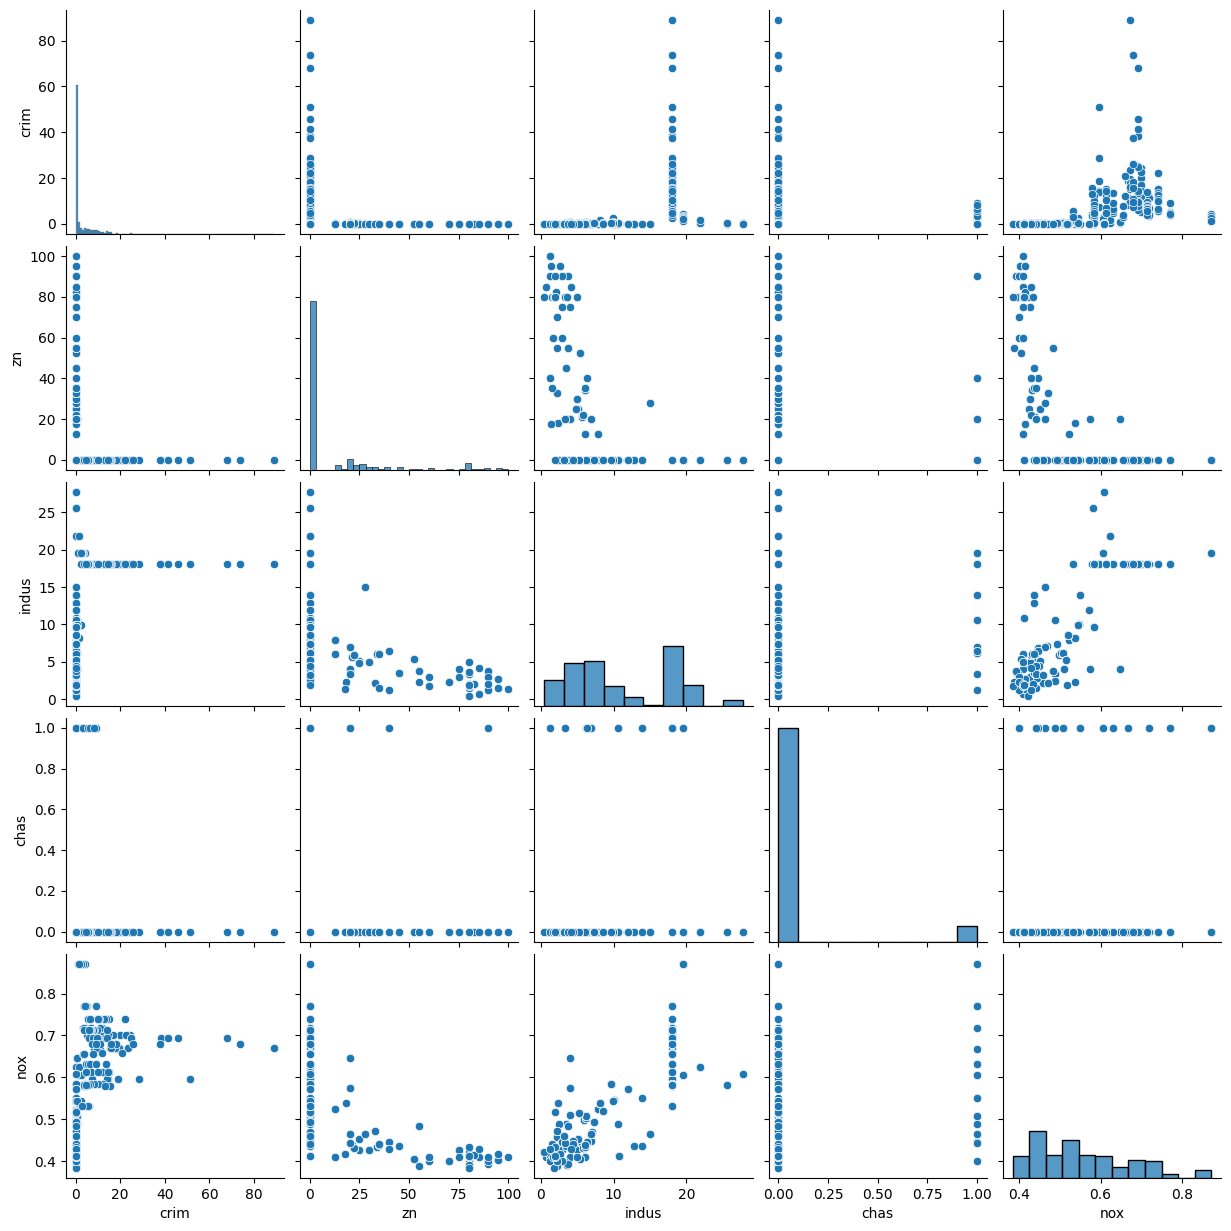

In [ ]:
sns.pairplot(Boston[['crim', 'zn','indus', 'chas', 'nox']])

### 2. Modeling (Autocorrelation and Normality)

In [ ]:
terms0 = Boston.columns.drop(['indus', 'age', 'medv'])
X0 = MS(terms0).fit_transform(Boston)
y0 = Boston['medv']
model0 = sm.OLS(y0, X0)
results0 = model0.fit()
results0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     136.8
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          1.73e-135
Time:                        04:29:08   Log-Likelihood:                -1505.0
No. Observations:                 506   AIC:                             3032.
Df Residuals:                     495   BIC:                             3078.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.4517      4.903      8.454      0.000      31.818      51.086
crim          -0.1217      0.033     -3.696      0.000      -0.186      -0.057
zn             0.0462      0.014      3.378      0.001       0.019       0.073
chas           2.8719      0.863      3.329      0.001       1.177       4.567
nox          -18.2624      3.565     -5.122      0.000     -25.267     -11.258
rm             3.6730      0.409      8.978      0.000       2.869       4.477
dis           -1.5160      0.188     -8.078      0.000      -1.885      -1.147
rad            0.2839      0.064      4.440      0.000       0.158       0.410
tax           -0.0123      0.003     -3.608      0.000      -0.019      -0.006
ptratio       -0.9310      0.130     -7.138      0.000      -1.187      -0.675
lstat         -0.5465      0.047    -11.519      0.000      -0.640      -0.453
==============================================================================
Omnibus:                      172.594   Durbin-Watson:                   1.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.971
Skew:                           1.486   Prob(JB):                    2.28e-158
Kurtosis:                       8.060   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Condition Number for Detecting Collinearity

The condition number is commonly used to detect collinearity in regression analysis or other linear algebra applications. Collinearity refers to the situation where two or more independent variables in a model are highly correlated, which can lead to instability and inaccurate coefficient estimates. Here’s how the condition number is used to assess collinearity:

### Condition Number and Collinearity
In multiple linear regression, the condition number $\kappa(X) $ of the design matrix $X $ can be used to assess collinearity. The condition number is calculated as:

$$
\kappa(X) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}
$$
where:
- $\sigma_{\text{max}} $ is the largest singular value of matrix $X $
- $\sigma_{\text{min}} $ is the smallest singular value of matrix $X $

### Collinearity Assessment Criteria
The condition number helps in identifying the degree of collinearity based on the following thresholds:

- **1 ≤ $\kappa(X) $ < 10**: Little to no collinearity, and the model is usually stable.
- **10 ≤ $\kappa(X)$ < 30**: Moderate collinearity is present, which may affect the model estimation to some extent.
- **$\kappa(X) \geq 30$**: Severe collinearity is present, indicating that the model estimates are likely very unstable, and coefficient estimates may be unreliable.

### Key Points
- **High Condition Number Indicates Collinearity**: A large condition number suggests that the columns of matrix $X $ are highly correlated, leading to collinearity. This makes it difficult for the model to accurately estimate the coefficients due to overlapping information among the variables.
- **Standardizing Data**: It is common to standardize data before calculating the condition number to eliminate the influence of different scales or units on the results.

By evaluating the condition number, you can effectively detect multicollinearity issues in a model and take appropriate actions, such as removing correlated variables or applying techniques like principal component regression, to address the impact of collinearity.



### Interaction Terms

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
terms0 = Boston.columns.drop(['indus', 'age', 'medv'])
y = Boston['medv']
X = poly.fit_transform(Boston)
Xb = sm.add_constant(X)
mod = sm.OLS(y, Xb)
res = mod.fit()
res.summary()

### 3. High-leverage points

### 1. Code Explanation
https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.influence_plot.html

external:bool

Whether to use externally or internally studentized residuals. It is recommended to leave external as True (default).

external residual represents the deleted residual.

### 2. What the Plot Represents
- Row labels for the observations in which the leverage, measured by the diagonal of the hat matrix, is high or the residuals are large, as the combination of large residuals and a high influence value indicates an influence point. The value of large residuals can be controlled using the alpha parameter. Large leverage points are identified as hat_i > 2 * (df_model + 1)/nobs.


- Cook's Distance measures the influence of each data point on the overall fit of the model; a larger value indicates that the data point has a more substantial impact on the model’s estimates.

- While leverage (the X-axis) indicates how much a data point differs in the independent variable space (i.e., how far it is from other points), the size of the points is determined by Cook's Distance, which takes into account both leverage and the residuals.



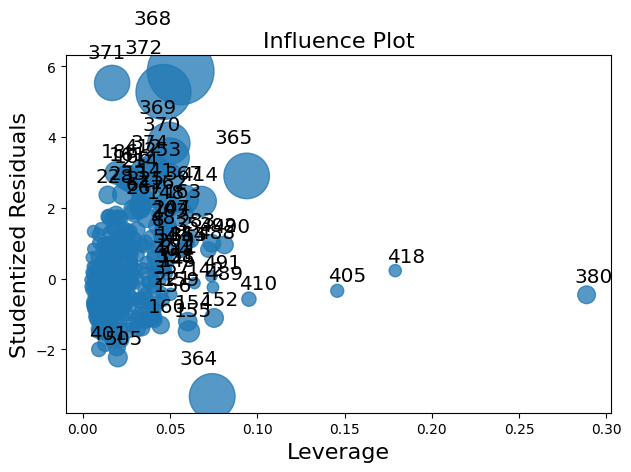

In [ ]:
fig = sm.graphics.influence_plot(results0,criterion='cooks',)
fig.tight_layout(pad=1.0)

In [ ]:
df = Boston[terms0.append(pd.Index(["medv"]))]
print("the scale of raw data:", df.shape)
# obtain Cook's distance
lm_cooksd = results0.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(Boston["medv"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n",
    lm_cooksd[out_d])
print("lenth:", len(lm_cooksd[out_d]))
subset = ~df.index.isin(df.index[out_d].tolist())
Boston = Boston.iloc[subset] #remove outliers and fit again

the scale of raw data: (506, 11)
Critical Cooks distance: 0.007905138339920948
Index([ 64, 141, 147, 148, 152, 154, 155, 161, 162, 163, 166, 186, 195, 203,
       204, 214, 225, 233, 253, 257, 262, 267, 364, 365, 367, 368, 369, 370,
       371, 372, 373, 374, 412, 414, 505],
      dtype='int64') 
 [0.01329934 0.02173983 0.00979841 0.01443025 0.00908367 0.00853298
 0.01304382 0.01869054 0.01965916 0.01790276 0.01993654 0.01576652
 0.01044182 0.00874269 0.00984125 0.02104834 0.01580356 0.01208574
 0.03651585 0.00915711 0.0102128  0.01229575 0.07901449 0.07837216
 0.02796378 0.17375061 0.06705612 0.05504457 0.04493082 0.11647176
 0.00972305 0.03487719 0.02949299 0.03143423 0.00914525]
lenth: 35


In [ ]:
terms0 = Boston.columns.drop(['indus', 'age', 'medv'])
X0 = MS(terms0).fit_transform(Boston)
y0 = Boston['medv']
model0 = sm.OLS(y0, X0)
results0 = model0.fit()
results0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     209.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          3.88e-164
Time:                        04:33:25   Log-Likelihood:                -1223.5
No. Observations:                 471   AIC:                             2469.
Df Residuals:                     460   BIC:                             2515.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     29.0769      3.807      7.638      0.000      21.595      36.558
crim          -0.1163      0.023     -5.009      0.000      -0.162      -0.071
zn             0.0345      0.010      3.446      0.001       0.015       0.054
chas           2.0235      0.679      2.978      0.003       0.688       3.359
nox          -12.2886      2.670     -4.603      0.000     -17.535      -7.043
rm             4.1577      0.355     11.728      0.000       3.461       4.854
dis           -1.0071      0.139     -7.252      0.000      -1.280      -0.734
rad            0.1869      0.046      4.078      0.000       0.097       0.277
tax           -0.0125      0.002     -5.193      0.000      -0.017      -0.008
ptratio       -0.7400      0.093     -7.985      0.000      -0.922      -0.558
lstat         -0.4667      0.038    -12.273      0.000      -0.541      -0.392
==============================================================================
Omnibus:                       30.062   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.131
Skew:                           0.589   Prob(JB):                     2.35e-08
Kurtosis:                       3.636   Cond. No.                     1.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. Heteroscedasticity

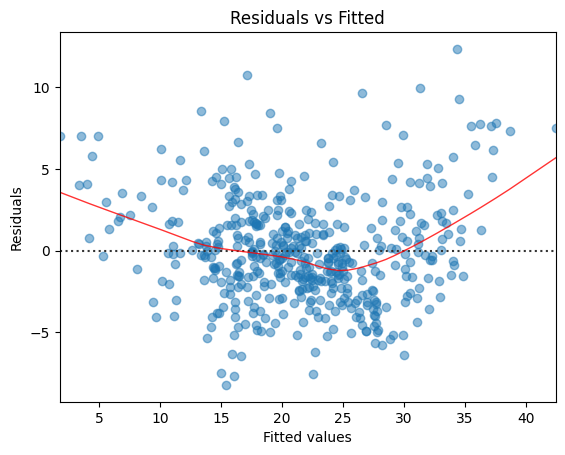

In [ ]:
# fitted values
model_fitted_y = results0.fittedvalues
df = Boston[terms0.append(pd.Index(["medv"]))]
#  Plot
plot = sns.residplot(x=model_fitted_y, y='medv', data=df, lowess=True,
                     scatter_kws={'alpha': 0.5},
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals');

### Test for Heteroscedasticity

The Breusch-Pagan test is used to detect heteroscedasticity in a regression model.


- Lagrange multiplier statistic: A statistic used to test for heteroscedasticity.
- p-value: The p-value associated with the Lagrange multiplier statistic, indicating the significance level.
- f-value: The F-test statistic, another method of testing for heteroscedasticity.
- f p-value: The p-value corresponding to the F-test statistic.

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(results0.resid, results0.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 47.544626124407486),
 ('p-value', 7.515065253032473e-07),
 ('f-value', 5.164777534185411),
 ('f p-value', 3.484800778925123e-07)]

### 5. Collinearity



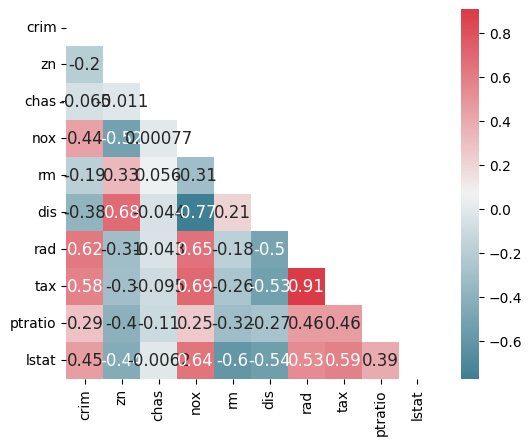

In [ ]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
df = Boston[terms0]
corr = df.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12});

In [ ]:
terms0 = Boston.columns.drop(['indus', 'age', 'medv', 'rad']) #drop rad because of high correlation
X0 = MS(terms0).fit_transform(Boston)
y0 = Boston['medv']
model0 = sm.OLS(y0, X0)
results0 = model0.fit()
results0.summary() #Conditional Number decrease

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     223.0
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          8.62e-162
Time:                        04:37:08   Log-Likelihood:                -1231.9
No. Observations:                 471   AIC:                             2484.
Df Residuals:                     461   BIC:                             2525.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     23.7138      3.633      6.528      0.000      16.575      30.853
crim          -0.0875      0.022     -3.891      0.000      -0.132      -0.043
zn             0.0298      0.010      2.947      0.003       0.010       0.050
chas           2.3455      0.686      3.419      0.001       0.997       3.694
nox          -11.0369      2.696     -4.093      0.000     -16.336      -5.738
rm             4.4787      0.351     12.743      0.000       3.788       5.169
dis           -0.9340      0.140     -6.670      0.000      -1.209      -0.659
tax           -0.0050      0.002     -3.166      0.002      -0.008      -0.002
ptratio       -0.6880      0.093     -7.371      0.000      -0.871      -0.505
lstat         -0.4628      0.039    -11.972      0.000      -0.539      -0.387
==============================================================================
Omnibus:                       37.704   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.320
Skew:                           0.669   Prob(JB):                     8.75e-11
Kurtosis:                       3.755   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 ### 6. Only focus on the independent variables which have linear relationship with dependent variable

In [ ]:
terms0 = Boston.columns.drop(['zn','crim','nox', 'indus', 'chas', 'age', 'rad', 'tax',
       'ptratio','medv'])
X0 = MS(terms0).fit_transform(Boston)
y0 = Boston['medv']
model0 = sm.OLS(y0, X0)
results0 = model0.fit()
results0.summary() #Conditional number pretty small

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     397.9
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          3.30e-128
Time:                        04:39:06   Log-Likelihood:                -1328.3
No. Observations:                 471   AIC:                             2665.
Df Residuals:                     467   BIC:                             2681.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2260      3.061     -0.074      0.941      -6.241       5.789
rm             4.9237      0.412     11.950      0.000       4.114       5.733
dis           -0.1157      0.109     -1.065      0.287      -0.329       0.098
lstat         -0.6756      0.042    -16.193      0.000      -0.758      -0.594
==============================================================================
Omnibus:                       23.299   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.129
Skew:                           0.484   Prob(JB):                     1.29e-06
Kurtosis:                       3.666   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df = Boston[terms0.append(pd.Index(["medv"]))]
print("the scale of raw data:", df.shape)
# obtain Cook's distance
lm_cooksd = results0.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(Boston["medv"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n",
    lm_cooksd[out_d])
print("lenth:", len(lm_cooksd[out_d]))
subset = ~df.index.isin(df.index[out_d].tolist())
Boston = Boston.iloc[subset]
terms0 = Boston.columns.drop(['zn','crim','nox', 'indus', 'chas', 'age', 'rad', 'tax',
       'ptratio','medv'])
X0 = MS(terms0).fit_transform(Boston)
y0 = Boston['medv']
model0 = sm.OLS(y0, X0)
results0 = model0.fit()
results0.summary()

the scale of raw data: (471, 4)
Critical Cooks distance: 0.008492569002123142
Index([  7,   8,  48,  98, 126, 144, 157, 180, 181, 202, 209, 211, 224, 228,
       256, 261, 264, 268, 280, 282, 283, 366, 375, 380, 384, 386, 388, 401,
       406, 407, 408, 409, 416, 419, 453],
      dtype='int64') 
 [0.02169153 0.05940147 0.05406607 0.02042813 0.00929779 0.01703453
 0.02329457 0.01594223 0.01596551 0.01429509 0.01583647 0.01492281
 0.02776417 0.03747403 0.02052313 0.03238051 0.00870719 0.02037242
 0.02882692 0.02784412 0.06419746 0.0190412  0.03331704 0.02784382
 0.02981085 0.01592917 0.01634719 0.01131663 0.03267049 0.01664871
 0.0104594  0.01220537 0.02597409 0.02595754 0.01500709]
lenth: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     467.7
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          2.98e-135
Time:                        04:39:54   Log-Likelihood:                -1129.2
No. Observations:                 436   AIC:                             2266.
Df Residuals:                     432   BIC:                             2283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5308      2.784      0.550      0.583      -3.941       7.002
rm             4.6083      0.384     11.994      0.000       3.853       5.363
dis           -0.1200      0.091     -1.317      0.189      -0.299       0.059
lstat         -0.6956      0.036    -19.066      0.000      -0.767      -0.624
==============================================================================
Omnibus:                        2.630   Durbin-Watson:                   0.949
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.620
Skew:                           0.189   Prob(JB):                        0.270
Kurtosis:                       2.958   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(results0.resid, results0.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 26.919499773482624),
 ('p-value', 6.120624511648595e-06),
 ('f-value', 9.475905024157932),
 ('f p-value', 4.4855890954201265e-06)]

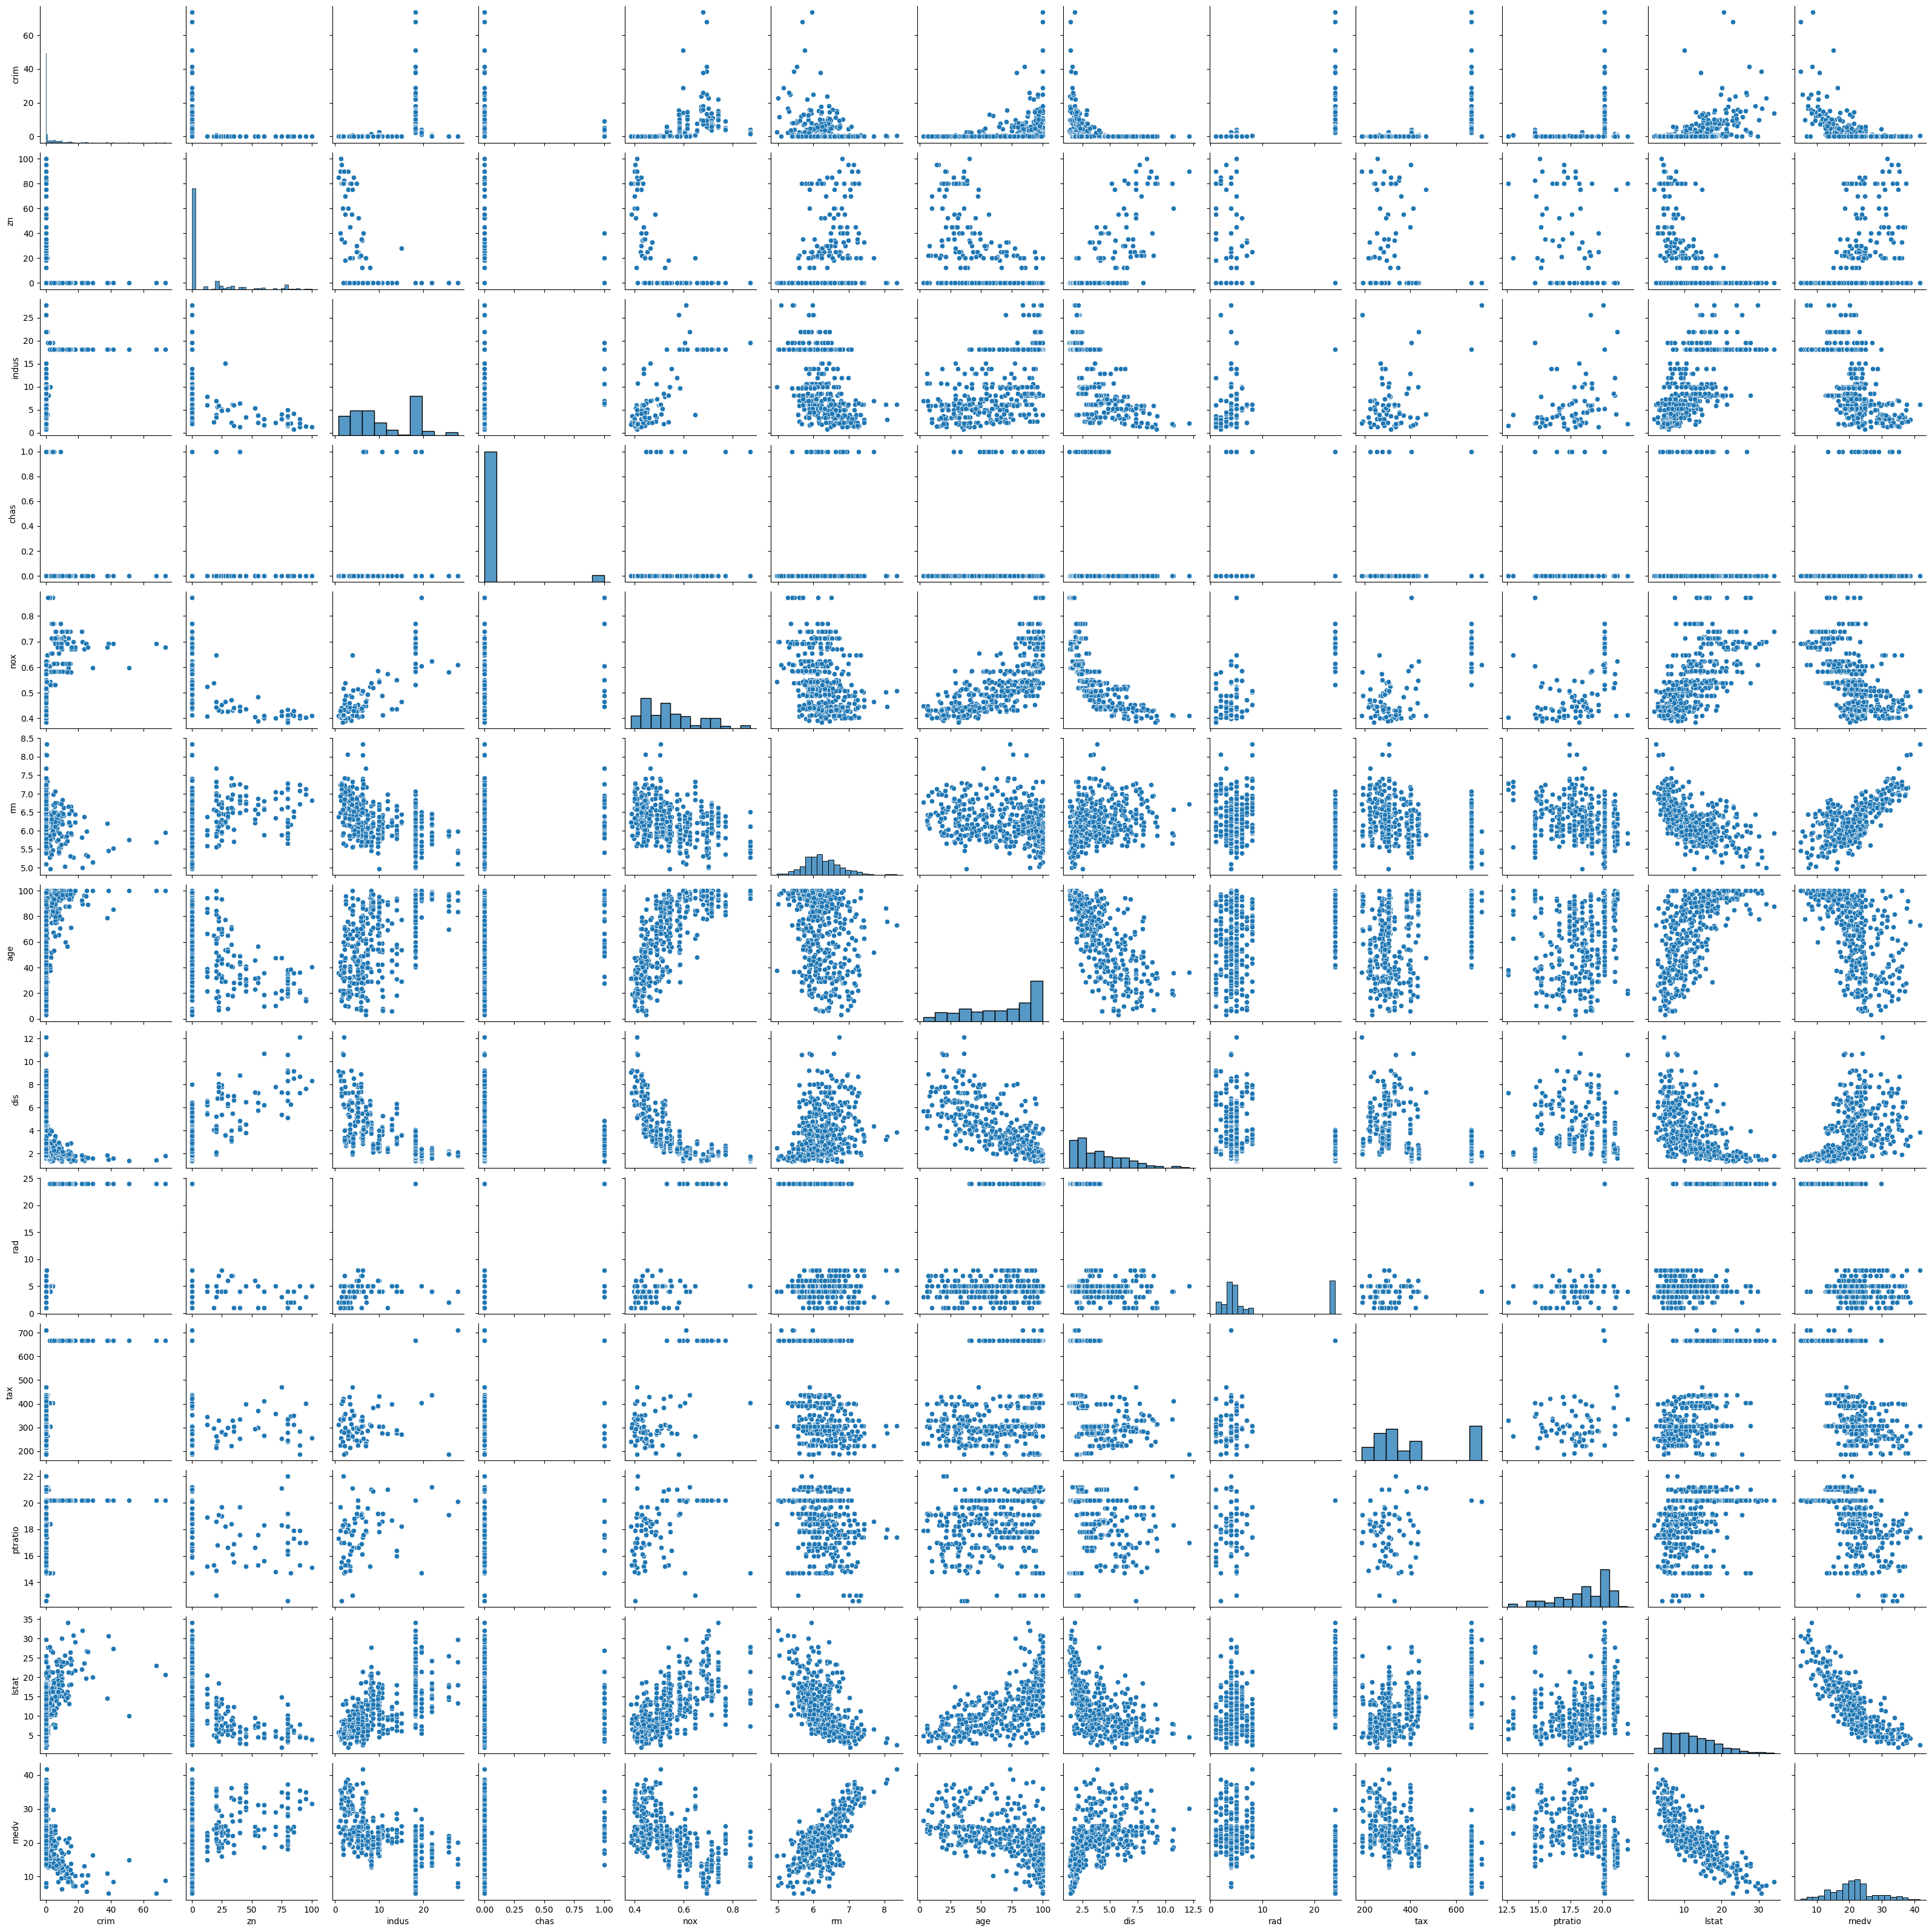

In [ ]:
sns.pairplot(Boston)